In [19]:
import sys
sys.path.append('../')

from src.data.loader import get_equity_data
from src.features.signals import add_rsi
from src.backtest.simple_backtester import simple_strategy_signals, backtest_returns, summarize_performance
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
df = get_equity_data("AAPL", period="6mo")

/Users/jamespecore/Documents/Github/data_engineering_portfolio_2025/ai-financial-signals-pipeline/notebooks/../src/data/loader.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


In [21]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [
        col[0].lower() if col[0] != 'Date' else 'date'
        for col in df.columns
    ]
else:
    df.columns = [col.lower() for col in df.columns]

print(df.columns)  # confirm flat, lowercase columns

Index(['date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


In [22]:
df = add_rsi(df, window=14)
print(df[['date', 'close', 'rsi_14']].tail())

          date       close     rsi_14
118 2025-07-11  211.160004  71.727976
119 2025-07-14  208.619995  64.004704
120 2025-07-15  209.110001  67.826770
121 2025-07-16  210.160004  67.551011
122 2025-07-17  210.020004  68.729220


In [23]:
df = simple_strategy_signals(df)
print(df[['date', 'rsi_14', 'position']].tail())

          date     rsi_14  position
118 2025-07-11  71.727976      -1.0
119 2025-07-14  64.004704      -1.0
120 2025-07-15  67.826770       0.0
121 2025-07-16  67.551011       0.0
122 2025-07-17  68.729220       0.0


In [24]:
df = backtest_returns(df)
print(df[['date', 'returns', 'strategy_returns']].tail())

          date   returns  strategy_returns
118 2025-07-11 -0.005885          0.005885
119 2025-07-14 -0.012029          0.012029
120 2025-07-15  0.002349          0.000000
121 2025-07-16  0.005021          0.000000
122 2025-07-17 -0.000666         -0.000000


In [25]:
metrics = summarize_performance(df)
print("Strategy Performance:", metrics)

Strategy Performance: {'total_return': 0.25964908180404656, 'sharpe_ratio': 1.851620173295309}


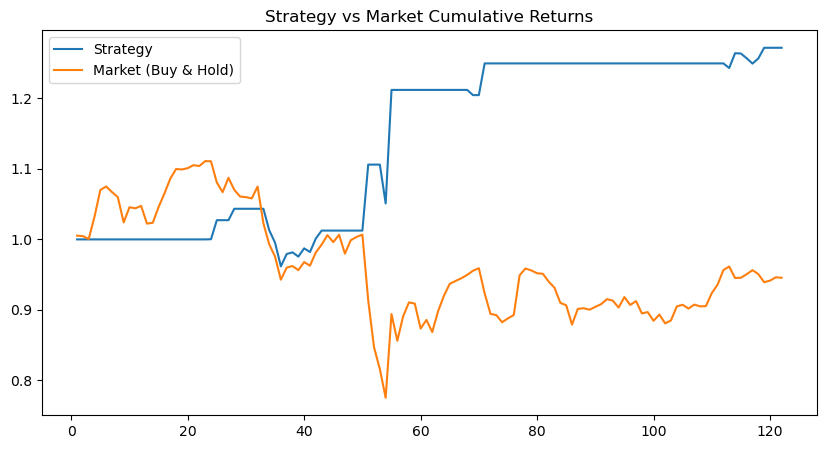

In [26]:
df['cum_strategy'] = (1 + df['strategy_returns']).cumprod()
df['cum_market'] = (1 + df['returns']).cumprod()

plt.figure(figsize=(10,5))
plt.plot(df['cum_strategy'], label='Strategy')
plt.plot(df['cum_market'], label='Market (Buy & Hold)')
plt.legend()
plt.title('Strategy vs Market Cumulative Returns')
plt.show()